In [2]:
import gym
import math
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.utils import clip_grad_norm_
from collections import deque
#import pybullet_envs
!pip install box2d-py
!pip install gym[Box_2D]

     |████████████████████████████████| 450kB 2.8MB/s 


In [8]:
env_name = "MountainCarContinuous-v0" #"MountainCarContinuous-v0"  #Pendulum-v0 LunarLanderContinuous-v2
env = gym.make(env_name)


print("action space: ", env.action_space.shape[0])
print("observation space ", env.env.observation_space.shape[0])
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using: ", device)

GAMMA = 0.9
ENTROPY_BETA = 0.001  
CLIP_GRAD = .1
LR_c = 1e-3
LR_a = 1e-3

HIDDEN_SIZE = 128

action space:  1
observation space  2
Using:  cpu


In [0]:
class Critic(nn.Module):
    def __init__(self, input_shape):
        super(Critic, self).__init__()
        self.net = nn.Sequential(nn.Linear(input_shape, HIDDEN_SIZE),
                                 nn.ReLU(),
                                 nn.Linear(HIDDEN_SIZE,HIDDEN_SIZE),
                                 nn.ReLU(),
                                 nn.Linear(HIDDEN_SIZE, 1))
    
    def forward(self,x):
        x = self.net(x)
        return x
      
class Actor(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(Actor, self).__init__()
        self.net = nn.Sequential(nn.Linear(input_shape, HIDDEN_SIZE),
                                 nn.ReLU(),
                                 nn.Linear(HIDDEN_SIZE,HIDDEN_SIZE),
                                 nn.ReLU(),
                                 )
        self.mean = nn.Sequential(nn.Linear(HIDDEN_SIZE, output_shape),
                                  nn.Tanh())                    # tanh squashed output to the range of -1..1
        self.variance =nn.Sequential(nn.Linear(HIDDEN_SIZE, output_shape),
                                     nn.Softplus())             # log(1 + e^x) has the shape of a smoothed ReLU
    
    def forward(self,x):
        x = self.net(x)
        return self.mean(x), self.variance(x)      

      


In [0]:
def test_net(count = 10):
    rewards = 0.0
    steps = 0
    entropys = 0.0
    for _ in range(count):
        obs = env.reset()

        while True:
            obs_v = torch.from_numpy(obs).unsqueeze(0).float()
            mean_v, var_v = actor(obs_v.to(device))
            action, _, entropy = sample(mean_v[0].cpu(), var_v[0].cpu()) #[0]
            obs, reward, done, info = env.step(action.numpy())
            
            rewards += reward
            entropys += np.mean(entropy.detach().numpy())
            steps += 1
            if done:
                break

    return rewards/count, entropys/count, steps/count
  
# def calc_actions(mean, variance):
  
#     sigma = torch.sqrt(variance)
#     m = Normal(mean, sigma)
#     actions = m.sample()
#     actions = torch.clamp(actions, -1, 1) # usually clipping between -1,1 but pendulum env has action range of -2,2
#     return actions

# def calc_logprob(mu_v, var_v, actions_v):
#     # calc log(pi):
#     # torch.clamp to prevent division on zero if variance is to small 
#     p1 = - ((actions_v - mu_v) ** 2) / (2*var_v.clamp(min=1e-3))
#     p2 = - torch.log(torch.sqrt(2 * math.pi * var_v))
#     return p1 + p2
  
  
def compute_returns(rewards,masks, gamma=GAMMA):
    R = 0 #pred.detach()
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return torch.FloatTensor(returns).reshape(-1).unsqueeze(1)

def sample(mean, variance):
  """
  Calculates the actions, log probs and entropy based on a normal distribution by a given mean and variance.
  
  ====================================================
  
  calculate log prob:
  log_prob = -((action - mean) ** 2) / (2 * var) - log(sigma) - log(sqrt(2 *pi))
  
  calculate entropy:
  entropy =  0.5 + 0.5 * log(2 *pi * sigma) 
  entropy here relates directly to the unpredictability of the actions which an agent takes in a given policy.
  The greater the entropy, the more random the actions an agent takes.
  
  """
  sigma = torch.sqrt(variance)
  m = Normal(mean, sigma)
  actions = m.sample()
  actions = torch.clamp(actions, -1, 1) # usually clipping between -1,1 but pendulum env has action range of -2,2
  logprobs = m.log_prob(actions)
  entropy = m.entropy()  # Equation: 0.5 + 0.5 * log(2 *pi * sigma)
    
  return actions, logprobs, entropy


def run_optimization(logprob_batch, entropy_batch, values_batch, rewards_batch, masks):
    """
    Calculates the actor loss and the critic loss and backpropagates it through the Network
    
    ============================================
    Critic loss:
    c_loss = -logprob * advantage
    
    a_loss = 
    
    """
    
    log_prob_v = torch.cat(logprob_batch).to(device)
    entropy_v = torch.cat(entropy_batch).to(device)
    value_v = torch.cat(values_batch).to(device)
    
    

    rewards_batch = torch.FloatTensor(rewards_batch)
    masks = torch.FloatTensor(masks)
    discounted_rewards = compute_returns(rewards_batch, masks).to(device)
    
    # critic_loss
    c_optimizer.zero_grad()
    critic_loss = 0.5 * F.mse_loss(value_v, discounted_rewards) #+ ENTROPY_BETA * entropy.detach().mean()
    critic_loss.backward()
    clip_grad_norm_(critic.parameters(),CLIP_GRAD)
    c_optimizer.step()
    
    # A(s,a) = Q(s,a) - V(s)
    advantage = discounted_rewards - value_v.detach() 

    #actor_loss
    a_optimizer.zero_grad()
    actor_loss = (-log_prob_v * advantage).mean() + ENTROPY_BETA * entropy.detach().mean()
    actor_loss.backward()
    clip_grad_norm_(actor.parameters(),CLIP_GRAD)
    a_optimizer.step()
    
    return actor_loss, critic_loss

Episode: 490 | Ep_Reward: -0.33 | Average_100: -5.07

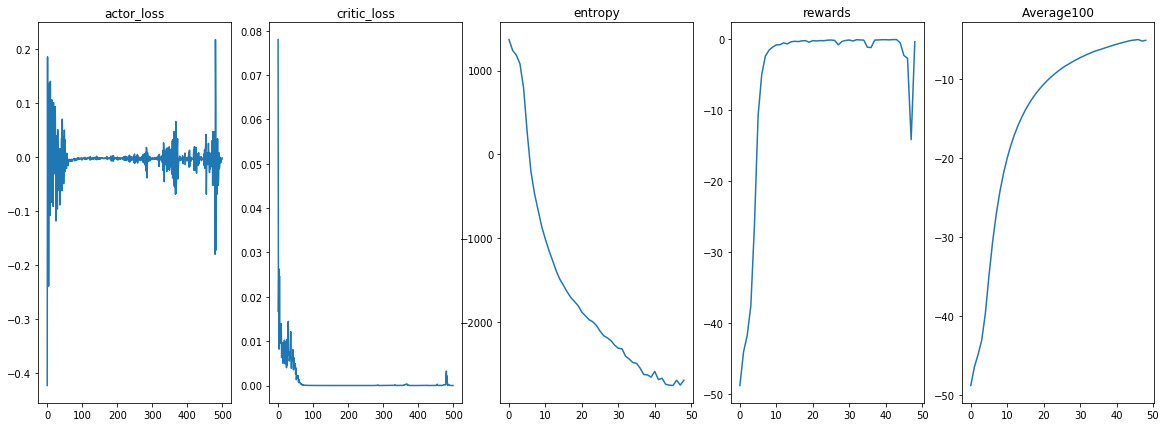

In [16]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
env.seed(42)

input_shape  = env.observation_space.shape[0]
output_shape = env.action_space.shape[0]

critic = Critic(input_shape).to(device)
actor = Actor(input_shape, output_shape).to(device)
c_optimizer = optim.RMSprop(params = critic.parameters(),lr = LR_c)
a_optimizer = optim.RMSprop(params = actor.parameters(),lr = LR_a)

max_episodes = 500

actor_loss_list = []
critic_loss_list = []
entropy_list = []


average_100 = []
plot_rewards = []
steps = 0
max_steps = 200

for ep in range(max_episodes):
    state = env.reset()
    done = False

    logprob_batch = []
    entropy_batch = []
    values_batch = []
    rewards_batch = []
    masks = []
    for step in range(max_steps):

        state = torch.from_numpy(state).float()
        mean, variance = actor(state.unsqueeze(0).to(device))   
        action, logprob, entropy = sample(mean.cpu(), variance.cpu())
        value = critic(state.unsqueeze(0).to(device))
        next_state, reward, done, _ = env.step(action[0].numpy())

        logprob_batch.append(logprob)
        entropy_batch.append(entropy)
        values_batch.append(value)
        rewards_batch.append(reward)  
        masks.append(1 - done)

        state = next_state

        if done:
          break

    actor_loss, critic_loss = run_optimization(logprob_batch, entropy_batch, values_batch, rewards_batch, masks)
    
    actor_loss_list.append(actor_loss)
    critic_loss_list.append(critic_loss)
    
    if ep != 0 and ep % 10 == 0:
      test_rewards, test_entropy, test_steps = test_net()
      entropy_list.append(test_entropy)
      plot_rewards.append(test_rewards)

      average_100.append(np.mean(plot_rewards[-100:]))
      print("\rEpisode: {} | Ep_Reward: {:.2f} | Average_100: {:.2f}".format(ep, test_rewards, np.mean(plot_rewards[-100:])), end = "", flush = True)
        
        

    

# PLOTTING RESULTS

plt.figure(figsize = (20,7))
plt.subplot(1,5,1)
plt.title("actor_loss")
plt.plot(actor_loss_list)
plt.subplot(1,5,2)
plt.title("critic_loss")
plt.plot(critic_loss_list)
plt.subplot(1,5,3)
plt.title("entropy")
plt.plot(entropy_list)
plt.subplot(1,5,4)
plt.title("rewards")
plt.plot(plot_rewards)
plt.subplot(1,5,5)
plt.title("Average100")
plt.plot(average_100)
plt.show()